# Compare Sentinel-2 Cloud probaility from Google Earth Engine (GEE) with SCL from ESA <img align="right" src="../Supplementary_data/dea_logo.jpg">
* **Compatability:** Notebook currently compatible with the `DEA Sandbox` environment
* **Products used:** 
[s2_l2a](https://explorer.digitalearth.africa/products/s2_l2a)
[COPERNICUS_S2_CLOUD_PROBABILITY](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_CLOUD_PROBABILITY)

## Background
GEE is a geospatial processing service. It has the option to be run through it's online JavaScript Code Editor, or can be accessed in python platforms such as Colab and Jupyter Notebooks. GEE provides access to many different datasets, climate data, PALSAR and MODIS (https://developers.google.com/earth-engine/datasets/catalog) which can be combined with data from DEA. 

To get started with GEE these links may help:
- User guides: https://developers.google.com/earth-engine/guides
- Get started using GEE with python: https://colab.research.google.com/github/google/earthengine-api/blob/master/python/examples/ipynb/ee-api-colab-setup.ipynb
- GEE developer guide for working with the S-2 cloud probability layer https://developers.google.com/earth-engine/tutorials/community/sentinel-2-s2cloudless

>**Note**: You will need a Google Earth Engine account subject to their terms and conditions (https://earthengine.google.com/terms/). [Sign up here.](https://signup.earthengine.google.com/)

## Description
This notebook demonstrates how to access Sentinel-1 data stored in GEE and determine where water (basic water proxy for demonstration only) is present in the landscape.

1. Install GEE API
2. Load python packages
3. Connect to datacube
4. Connect to GEE API
5. Load GEE imagery
6. Convert GEE image to numpy array
7. Load GA image

***


### Install GEE API

In [1]:
!pip install earthengine-api

You should consider upgrading via the '/env/bin/python3 -m pip install --upgrade pip' command.


### Install geehydro

geehydro decorates the folium map and allows us to add GEE layers directly

In [2]:
!pip install geehydro

You should consider upgrading via the '/env/bin/python3 -m pip install --upgrade pip' command.


### Load packages
Import Python packages that are used for the analysis.

In [3]:
import ee
import numpy as np
import matplotlib.pyplot as plt
import sys
import folium
import datacube
import geehydro
from branca.element import Figure

sys.path.append("../Scripts")
from deafrica_plotting import rgb

### Connect to the datacube

Connect to the datacube so we can access DEA data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [4]:
dc = datacube.Datacube(app='cloud_prb_comparison')

### Authenticate and initialize

Run the `ee.Authenticate` function to authenticate your access to Earth Engine servers and `ee.Initialize` to initialize it. Upon running the following cell you'll be asked to grant Earth Engine access to your Google account. Follow the instructions printed to the cell.

In [ ]:
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

## Define Area of Interest and find GEE and DEA Imagery

### Define parameters 

In [18]:
# Define parameters

# Dates
# NOTE: GEE dates are inclusive and GA are exclusive on the end date
start = '2020-12-04'
end_ga = '2020-12-05'
end_gee = '2020-12-06'

# Set the central latitude and longitude
central_lon=24.47736740112238
central_lat=-29.805050160799556

In [19]:
# Set the buffer to load around the central coordinates
buffer = 0.02 # must be small for .sampleRectangle() to work

# Compute the bounding box for the study area
study_area_lat = (central_lat - buffer, central_lat + buffer)
study_area_lon = (central_lon - buffer, central_lon + buffer)

# Compute the bounding box for the map area
map_area_lat = (central_lat - buffer*10, central_lat + buffer*10)
map_area_lon = (central_lon - buffer*10, central_lon + buffer*10)

### Load GEE imagery

To load imagery from GEE generally you will need to:
- define an area of interest and pass to `filterBounds`
- define a time period of interest and pass to `filterDate`
- select bands of interest
- reproject

Imagery without a set projection will be called in WGS 94. Sentinel-1 pixels in GEE are 10m in length.

>**Note**: All options for how to manipulate GEE objects can be found here https://developers.google.com/earth-engine/apidocs

In [20]:
# Define an area of interest.
aoi = ee.Geometry.Polygon(
  [[[study_area_lon[0], study_area_lat[0]],
    [study_area_lon[0], study_area_lat[1]],
    [study_area_lon[1], study_area_lat[1]],
    [study_area_lon[1], study_area_lat[0]]]], None, False)


# Filter image collection
img_cloud_prob = (ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY')
         .filterBounds(aoi)
         .filterDate(start,end_gee))

Let's collect some information about the datasets we are retrieving

In [21]:
img = img_cloud_prob.toBands()
bands = img.getInfo()['bands']

In [23]:
output_crs = bands[0]['crs']
resolution = (bands[0]['crs_transform'][4],bands[0]['crs_transform'][0])

In [24]:
sentinel_2_products = ['s2_l2a']
cloud_measurement = ["SCL"]
rgb_measurements = ['red', 'green', 'blue']

datasets = dc.find_datasets(product=sentinel_2_products,
              x= study_area_lon,
              y= study_area_lat,
              time=(start, end_ga))

### Display GA Imagery with S-2 Cloud Probaility and FMASK on a folium map

Not sure how geehydro is adding GEE layers, but either that or how we have constructed the cloud probability layer causes one of the GEE images to ignore the layer controls

In [25]:
location=[central_lat, central_lon]
zoom_start = 12

# Create a folium map object
my_map = folium.Map(location=location, zoom_start=zoom_start)

# Add our WMS as a refence layer
folium.raster_layers.WmsTileLayer(
    url="https://ows.digitalearth.africa/wms",
    name="DEAfrica Sentinel-2",
    fmt="image/png",
    layers='s2_l2a',
    style='simple_rgb',
    version='1.3.0',
    time=end_ga,
    transparent = True,
).add_to(my_map)

# add define the style for each individual s-2 cloudless probability granule and add it to map
# probably a smarter way of doing this
vis_params = {
   'bands':'probability',
   'min': 0,
   'max': 100
}
my_map.addLayer(img_cloud_prob.max(), vis_params, 'Cloud Probability')

# load fmask for map in horrible projection
ga_s2_fmask = dc.load(
          product=sentinel_2_products,
          measurements=cloud_measurement,
          lon= map_area_lon,
          lat= map_area_lat,
          time=(start, end_ga),
          output_crs='EPSG:3857',
          resolution=resolution
)

# reshape array for correct display
array = ga_s2_fmask.isel(time=0).to_array().transpose("y", "x", "variable").values    

folium.raster_layers.ImageOverlay(
    image=array,
    name="Sentinel-2 SCL",
    bounds= [[map_area_lat[0], map_area_lon[0]],[map_area_lat[1], map_area_lon[1]]], 
    opacity=1,
    interactive=False,
    cross_origin=False,
    zindex=4
).add_to(my_map)

# Add a layer control panel to the map.
my_map.add_child(folium.LayerControl())

#display folium map without ugly space beneath it
fig = Figure(width=800, height=800)
fig.add_child(my_map)

### Convert GEE image into a numpy array

The image returned to us is an ee.Image object. To integrate this with GA imagery, we need to convert the image object into an xarray.

In [26]:
probability_np_arrays = []
for band in bands:
    
    gee_image = img.select(band['id'])
    
    #need to manually set a unsigned int8 default value, 0 isnt safe so will use 255
    band_arrs = gee_image.sampleRectangle(region=aoi, defaultValue=255)

    band_arr_probability = band_arrs.get('probability')
    
    probability_np_arrays.append((band['id'], np.array(band_arr_probability.getInfo())))

### Load GA data

In [31]:
cloud_data = []
for dataset in datasets:
    id = dataset.metadata_doc['id']
    cloud_data.append((dataset.metadata_doc['properties']['sentinel:product_id'],dc.load(
              id=id,
              product=sentinel_2_products,
              x= study_area_lon,
              y= study_area_lat,
              time=(start, end_ga),
              output_crs=output_crs,
              measurements = cloud_measurement,
              resolution=resolution
            )))
    

In [32]:
reference_rgb = dc.load(
              product=sentinel_2_products,
              x= study_area_lon,
              y= study_area_lat,
              time=(start, end_ga),
              output_crs=output_crs,
              measurements = rgb_measurements,
              resolution=resolution,
              group_by='solar_day'
)

### Generate some charts

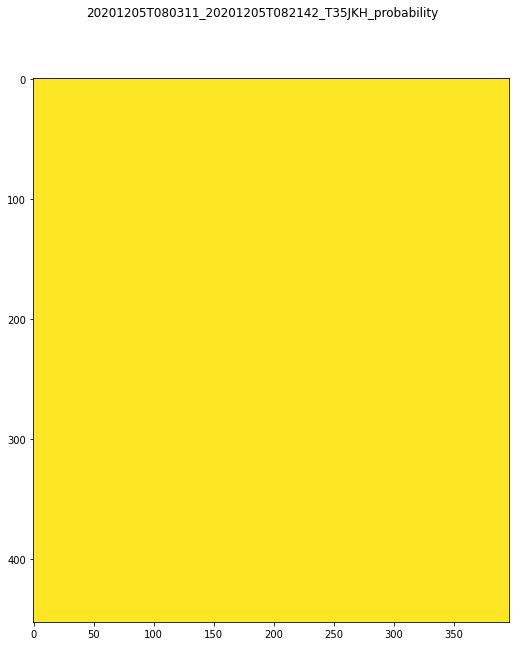

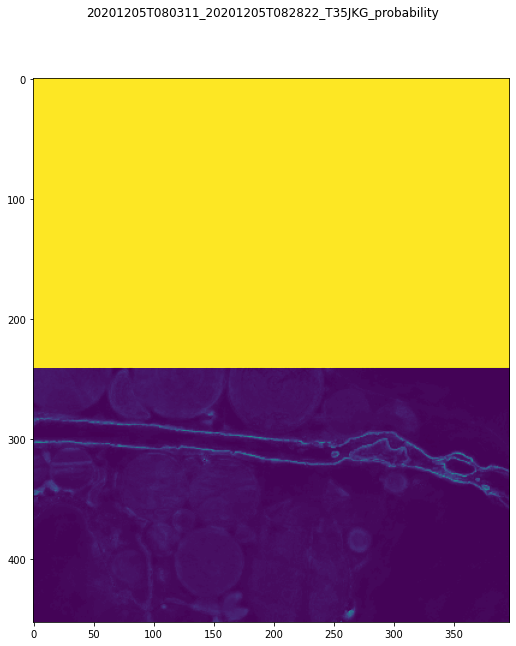

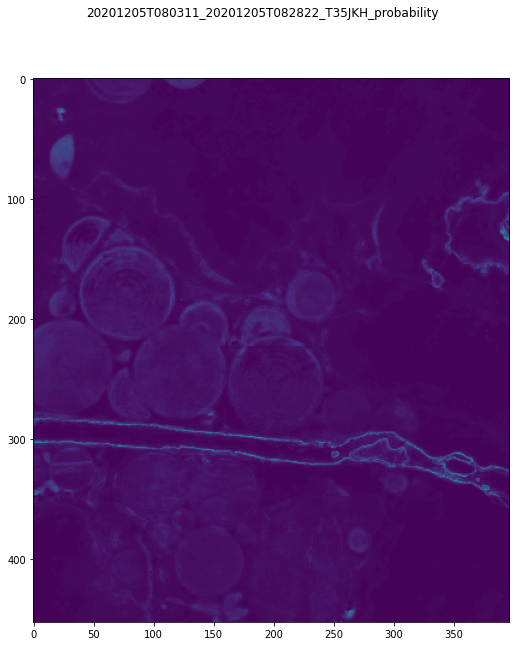

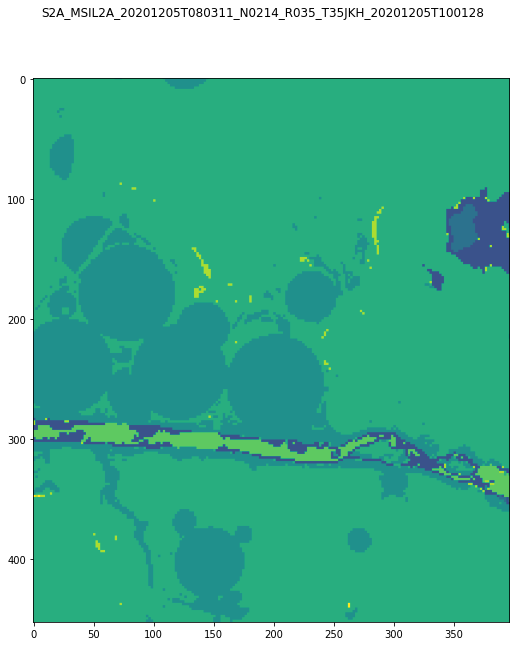

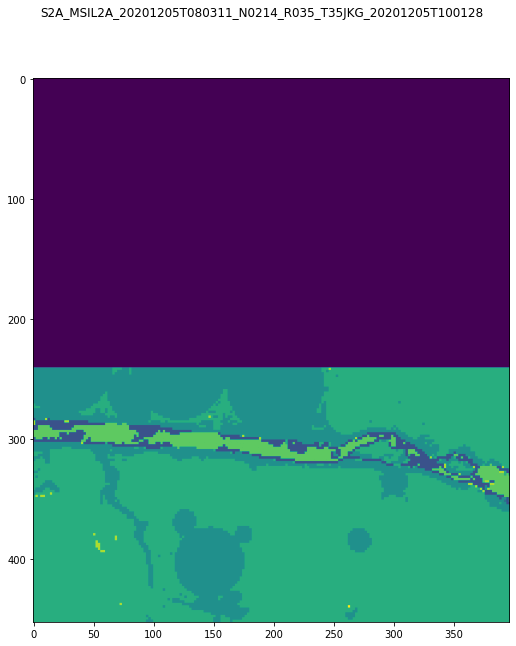

In [34]:
for probability_np_array in probability_np_arrays: 
    # Plot array
    plt.figure(figsize=(10, 10))
    plt.imshow(probability_np_array[1], vmin =0, vmax=100)
    plt.suptitle(probability_np_array[0])
    plt.show()

for cloud in cloud_data: 
    # Plot array
    plt.figure(figsize=(10, 10))
    plt.imshow(cloud[1][cloud_measurement[0]].squeeze(),vmin=0,vmax=8)
    plt.suptitle(cloud[0])
    plt.show()

In [ ]:
rgb(reference_rgb, bands=rgb_measurements, size=10)

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** May 2020

**Compatible datacube version:** 

In [ ]:
print(datacube.__version__)

## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)